## **Load and inspect the Tetouan dataset**



```
# This is formatted as code
```

**Load data directly from Google Drive**

In [25]:
import numpy as np
import tensorflow as tf
import random

seed = 42  # any integer
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import pandas as pd

file_path = "/content/drive/MyDrive/Deep_Learning/Coursework/Tetuan-City-power-consumption.xlsx"  # adjust path & name
df = pd.read_excel(file_path)
df.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [28]:
# See all column names
print(df.columns)
# Quick info about data types and missing values
df.info()

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2 Power Consumption', 'Zone 3 Power Consumption'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DateTime                  52416 non-null  datetime64[ns]
 1   Temperature               52416 non-null  float64       
 2   Humidity                  52416 non-null  float64       
 3   Wind Speed                52416 non-null  float64       
 4   general diffuse flows     52416 non-null  float64       
 5   diffuse flows             52416 non-null  float64       
 6   Zone 1 Power Consumption  52416 non-null  float64       
 7   Zone 2 Power Consumption  52416 non-null  float64       
 8   Zone 3 Power Consumption  52416 non-null  fl

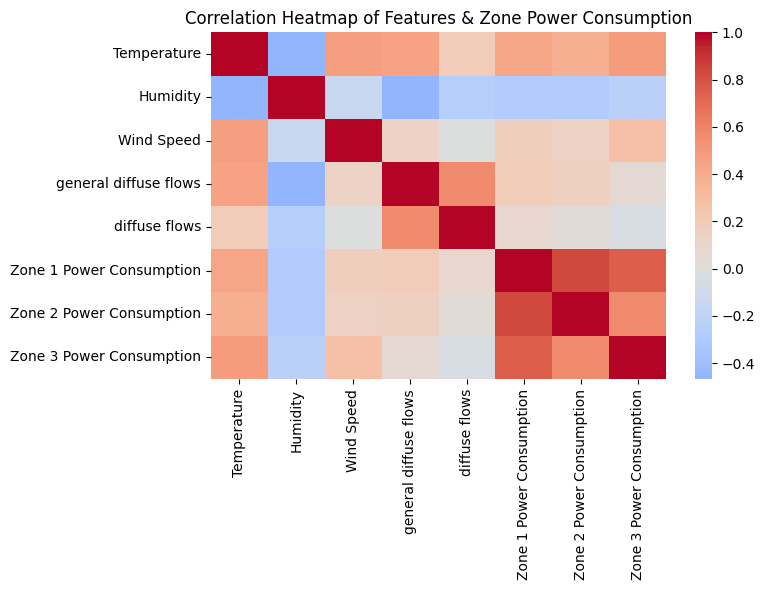

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[[
    "Temperature", "Humidity", "Wind Speed",
    "general diffuse flows", "diffuse flows",
    "Zone 1 Power Consumption",
    "Zone 2 Power Consumption",
    "Zone 3 Power Consumption"
]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Features & Zone Power Consumption")
plt.tight_layout()
plt.show()


## **Basic cleaning and feature selection**

In [30]:
import numpy as np

# 1) Define target (output) columns – the 3 zones
target_cols = [
    "Zone 1 Power Consumption",
    "Zone 2 Power Consumption",
    "Zone 3 Power Consumption"
]

# 2) Define feature (input) columns – weather + past loads
feature_cols = [
    "Temperature",
    "Humidity",
    "Wind Speed",
    "general diffuse flows",
    "diffuse flows",
] + target_cols   # we include the past loads as inputs too

# 3) Create a new DataFrame with only the columns we need
data_df = df[feature_cols].copy()

# 4) Drop any rows with missing values
data_df = data_df.dropna()

# 5) Convert to a NumPy array for modelling
data = data_df.values

print(data.shape)
data_df.head()

(52416, 8)


,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


## **Train / Validation / Test Split**

In [31]:

n = len(data)
train_size = int(n * 0.7)   # 70% train
val_size   = int(n * 0.15)  # 15% validation
test_size  = n - train_size - val_size  # remaining 15% test

train = data[:train_size]
val   = data[train_size:train_size + val_size]
test  = data[train_size + val_size:]

print("Train shape:", train.shape)
print("Val shape:  ", val.shape)
print("Test shape: ", test.shape)


Train shape: (36691, 8)
Val shape:   (7862, 8)
Test shape:  (7863, 8)


## **Scale features (normalise data)**

In [32]:
from sklearn.preprocessing import MinMaxScaler

# Creating scaler and fit ONLY on training data
scaler = MinMaxScaler()
scaler.fit(train)

# Transforming train, val, test
train_scaled = scaler.transform(train)
val_scaled   = scaler.transform(val)
test_scaled  = scaler.transform(test)

print("Train scaled shape:", train_scaled.shape)
print("Val scaled shape:  ", val_scaled.shape)
print("Test scaled shape: ", test_scaled.shape)


Train scaled shape: (36691, 8)
Val scaled shape:   (7862, 8)
Test scaled shape:  (7863, 8)


## **Create sliding windows (sequences) for LSTM and 1‑D CNN**

In [33]:
import numpy as np

WINDOW_SIZE = 24

def create_sequences(data_scaled, window_size, n_features, n_targets):
    X = []
    y = []
    for i in range(len(data_scaled) - window_size):
        window = data_scaled[i : i + window_size]
        target = data_scaled[i + window_size, -n_targets:]  # last columns are targets
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

n_features = train_scaled.shape[1]    # 8
n_targets  = 3                        # 3 zones

X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE, n_features, n_targets)
X_val,   y_val   = create_sequences(val_scaled,   WINDOW_SIZE, n_features, n_targets)
X_test,  y_test  = create_sequences(test_scaled,  WINDOW_SIZE, n_features, n_targets)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:",   X_val.shape)
print("y_val shape:",   y_val.shape)
print("X_test shape:",  X_test.shape)
print("y_test shape:",  y_test.shape)


X_train shape: (36667, 24, 8)
y_train shape: (36667, 3)
X_val shape: (7838, 24, 8)
y_val shape: (7838, 3)
X_test shape: (7839, 24, 8)
y_test shape: (7839, 3)


## **Build and train the LSTM model**

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential([
    LSTM(
        16,
        activation="tanh",
        return_sequences=False,
        input_shape=(WINDOW_SIZE, n_features)
    ),
    Dropout(0.2),
    Dense(n_targets)
])

lstm_model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 16)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,651 (6.45 KB)

 Trainable params: 1,651 (6.45 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    shuffle=False,
    verbose=1
)

Epoch 1/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0454 - mae: 0.1517 - val_loss: 0.0093 - val_mae: 0.0706
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0090 - mae: 0.0734 - val_loss: 0.0066 - val_mae: 0.0600
Epoch 3/50
108/287 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0060 - mae: 0.0603

KeyboardInterrupt: 

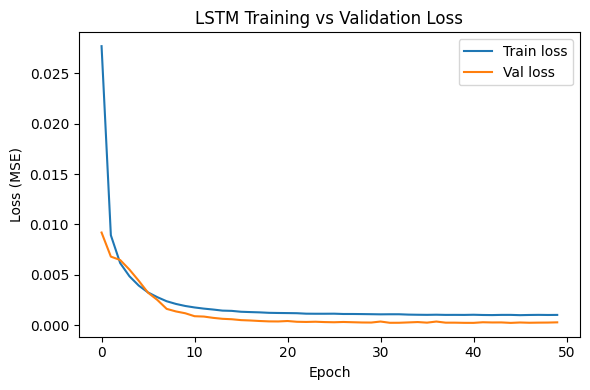

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history_lstm.history["loss"], label="Train loss")
plt.plot(history_lstm.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("LSTM Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

## **Evaluation**

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicting on test set
y_pred_lstm = lstm_model.predict(X_test)

def inverse_transform_targets(y_scaled):
    dummy = np.zeros((y_scaled.shape[0], n_features))
    dummy[:, -n_targets:] = y_scaled
    inv = scaler.inverse_transform(dummy)
    return inv[:, -n_targets:]

y_test_inv = inverse_transform_targets(y_test)
y_pred_lstm_inv = inverse_transform_targets(y_pred_lstm)

mae_list = []
rmse_list = []
r2_list = []

for i, zone_name in enumerate(["Zone 1", "Zone 2", "Zone 3"]):
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_lstm_inv[:, i])
    mse = mean_squared_error(y_test_inv[:, i], y_pred_lstm_inv[:, i])
    rmse = mse ** 0.5              # manual RMSE
    r2 = r2_score(y_test_inv[:, i], y_pred_lstm_inv[:, i])
    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)
    print(f"{zone_name} - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")

print("\nAverage over 3 zones:")
print(f"MAE:  {np.mean(mae_list):.3f}")
print(f"RMSE: {np.mean(rmse_list):.3f}")
print(f"R2:   {np.mean(r2_list):.3f}")

245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Zone 1 - MAE: 4910.858, RMSE: 5053.727, R2: 0.306
Zone 2 - MAE: 4365.148, RMSE: 4848.414, R2: 0.249
Zone 3 - MAE: 7707.047, RMSE: 8100.020, R2: -4.802

Average over 3 zones:
MAE:  5661.018
RMSE: 6000.720
R2:   -1.415


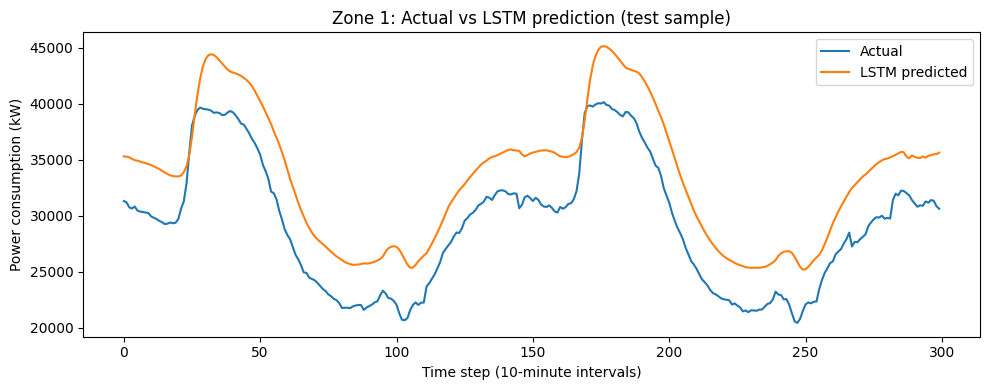

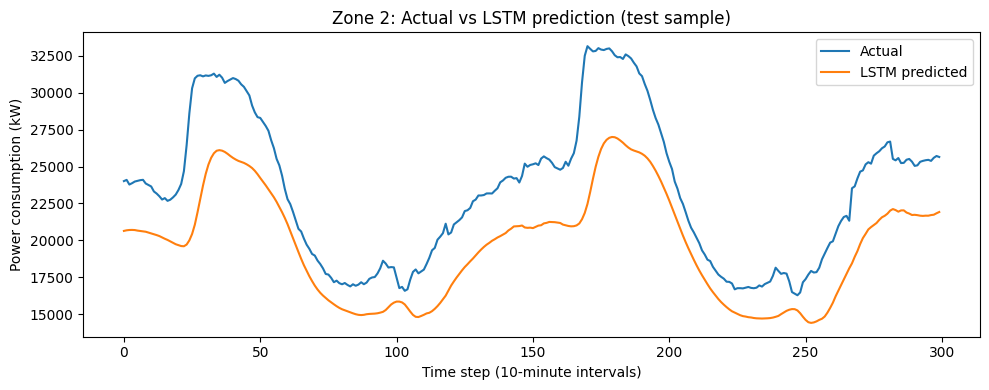

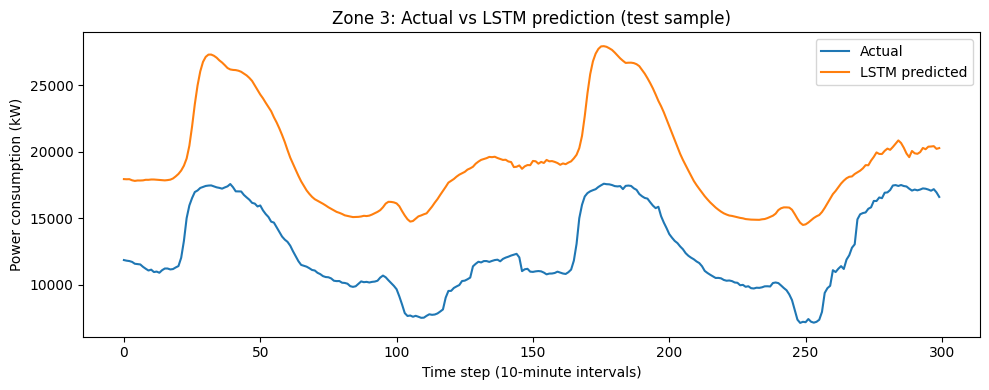

In [42]:
import matplotlib.pyplot as plt

n_points = 300  # number of test points to show

zone_names = ["Zone 1", "Zone 2", "Zone 3"]

for zone_idx, zone_name in enumerate(zone_names):
    plt.figure(figsize=(10,4))
    plt.plot(y_test_inv[:n_points, zone_idx], label="Actual")
    plt.plot(y_pred_lstm_inv[:n_points, zone_idx], label="LSTM predicted")
    plt.xlabel("Time step (10-minute intervals)")
    plt.ylabel("Power consumption (kW)")
    plt.title(f"{zone_name}: Actual vs LSTM prediction (test sample)")
    plt.legend()
    plt.tight_layout()
    plt.show()

## **1D-CNN**

## **Build and train the 1‑D CNN model**

In [43]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(WINDOW_SIZE, n_features)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(n_targets)  # 3 outputs
])

cnn_model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)
cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 22, 64)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 9, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,595 (119.51 KB)

 Trainable params: 30,595 (119.51 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,          # can increase too
    batch_size=64,
    shuffle=False,
    verbose=1
)

Epoch 1/50


KeyboardInterrupt: 

## **Evaluate the 1‑D CNN on the test set**

In [45]:
# Predict on test set with CNN
y_pred_cnn = cnn_model.predict(X_test)

# Reuse the same inverse function from before
def inverse_transform_targets(y_scaled):
    dummy = np.zeros((y_scaled.shape[0], n_features))
    dummy[:, -n_targets:] = y_scaled
    inv = scaler.inverse_transform(dummy)
    return inv[:, -n_targets:]

y_test_inv = inverse_transform_targets(y_test)
y_pred_cnn_inv = inverse_transform_targets(y_pred_cnn)

mae_list_cnn = []
rmse_list_cnn = []
r2_list_cnn = []

for i, zone_name in enumerate(["Zone 1", "Zone 2", "Zone 3"]):
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_cnn_inv[:, i])
    mse = mean_squared_error(y_test_inv[:, i], y_pred_cnn_inv[:, i])
    rmse = mse ** 0.5
    r2 = r2_score(y_test_inv[:, i], y_pred_cnn_inv[:, i])
    mae_list_cnn.append(mae)
    rmse_list_cnn.append(rmse)
    r2_list_cnn.append(r2)
    print(f"{zone_name} (CNN) - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")

print("\nCNN average over 3 zones:")
print(f"MAE:  {np.mean(mae_list_cnn):.3f}")
print(f"RMSE: {np.mean(rmse_list_cnn):.3f}")
print(f"R2:   {np.mean(r2_list_cnn):.3f}")


245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Zone 1 (CNN) - MAE: 10526.007, RMSE: 11951.658, R2: -2.882
Zone 2 (CNN) - MAE: 13494.259, RMSE: 14295.740, R2: -5.526
Zone 3 (CNN) - MAE: 4064.815, RMSE: 5189.884, R2: -1.382

CNN average over 3 zones:
MAE:  9361.694
RMSE: 10479.094
R2:   -3.263


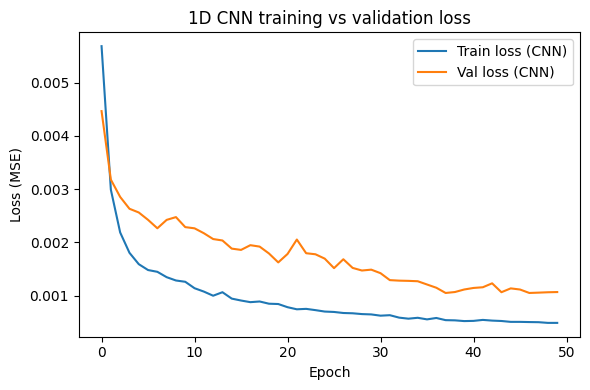

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history_cnn.history["loss"], label="Train loss (CNN)")
plt.plot(history_cnn.history["val_loss"], label="Val loss (CNN)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("1D CNN training vs validation loss")
plt.legend()
plt.tight_layout()
plt.show()


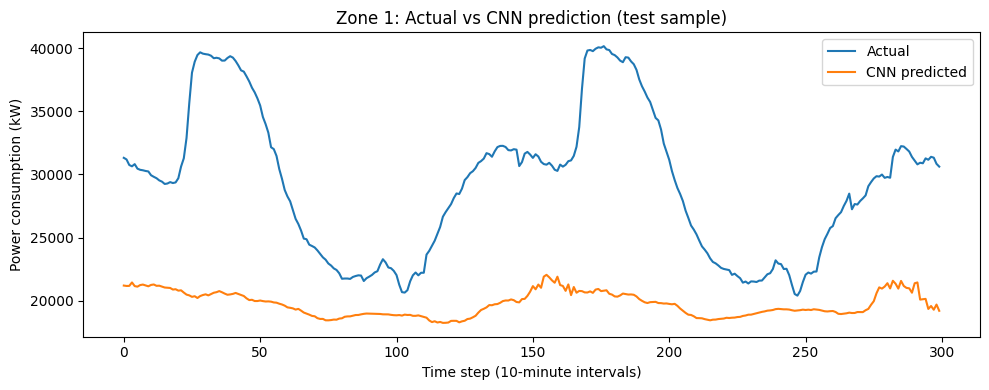

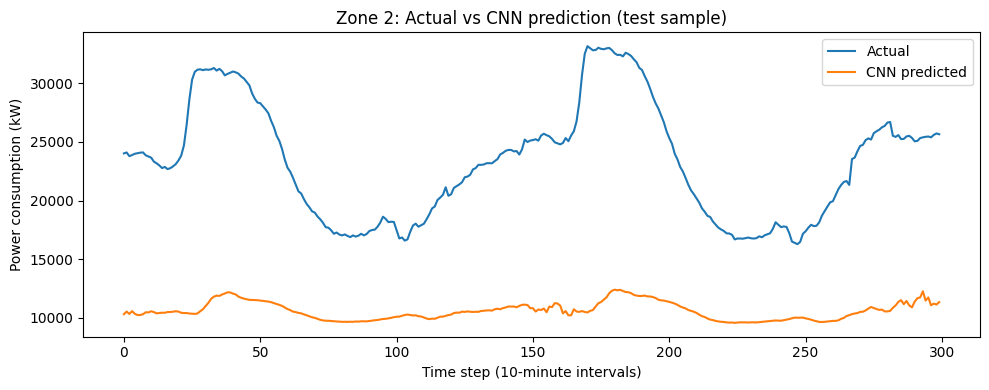

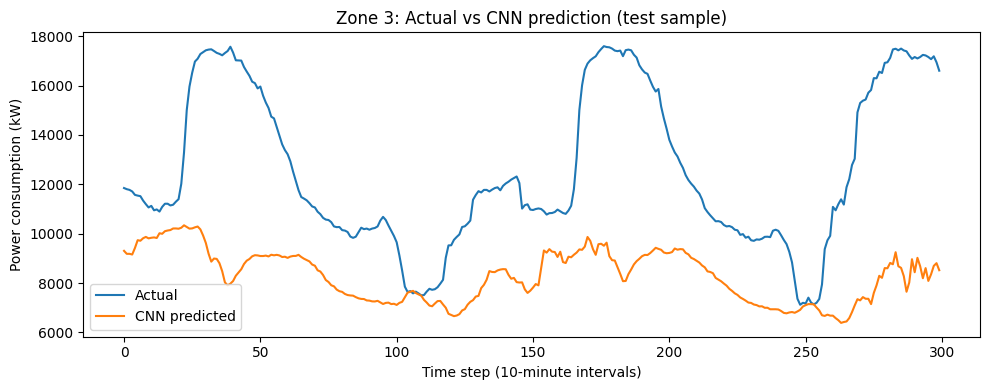

In [47]:
import matplotlib.pyplot as plt

n_points = 300                      # number of test points to show
zone_names = ["Zone 1", "Zone 2", "Zone 3"]

for zone_idx, zone_name in enumerate(zone_names):
    plt.figure(figsize=(10,4))
    plt.plot(y_test_inv[:n_points, zone_idx], label="Actual")
    plt.plot(y_pred_cnn_inv[:n_points, zone_idx], label="CNN predicted")
    plt.xlabel("Time step (10-minute intervals)")
    plt.ylabel("Power consumption (kW)")
    plt.title(f"{zone_name}: Actual vs CNN prediction (test sample)")
    plt.legend()
    plt.tight_layout()
    plt.show()


## **LSTM vs 1D CNN Comparison**

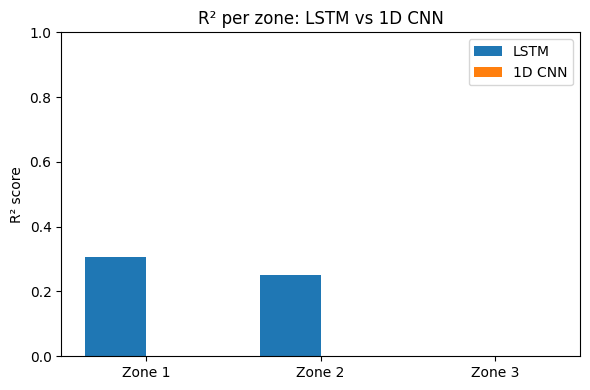

In [48]:
import numpy as np
import matplotlib.pyplot as plt

zones = ["Zone 1", "Zone 2", "Zone 3"]


r2_lstm = r2_list
r2_cnn  = r2_list_cnn

x = np.arange(len(zones))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, r2_lstm, width, label="LSTM")
plt.bar(x + width/2, r2_cnn,  width, label="1D CNN")

plt.xticks(x, zones)
plt.ylabel("R² score")
plt.ylim(0, 1)
plt.title("R² per zone: LSTM vs 1D CNN")
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
# Save LSTM model (the best performing one)
lstm_model.save('lstm_power_prediction_model.h5')

# Save CNN model (backup)
cnn_model.save('cnn_power_prediction_model.h5')

# Save the scaler
import joblib
joblib.dump(scaler, 'Tetuan_power_prediction_scaler.pkl')

['Tetuan_power_prediction_scaler.pkl']